# MNIST example with 3-conv. layer network

This example demonstrates the usage of `LRFinder` with a 3-conv. layer network on the MNIST dataset.

In [71]:
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

try:
    from torch_lr_finder import LRFinder
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder

## Loading MNIST

In [72]:
mnist_pwd = "../data"
batch_size= 256

In [73]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

trainset = MNIST(mnist_pwd, train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = MNIST(mnist_pwd, train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size * 2, shuffle=False, num_workers=0)

## Model

In [74]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
model = Net()

In [77]:
# Evaluate the initial weights 
named_params = model.named_parameters()
for name, module in named_params:
    print(f'- Module {name}\n \t \t mean: {module.mean()} \n \t \t max: {module.max()} \n \t \t min: {module.min()}')

- Module conv1.weight
 	 	 mean: -0.008412416093051434 
 	 	 max: 0.19864432513713837 
 	 	 min: -0.20022745430469513
- Module conv1.bias
 	 	 mean: -0.049846068024635315 
 	 	 max: 0.1648939996957779 
 	 	 min: -0.19886578619480133
- Module conv2.weight
 	 	 mean: -0.0003912231477443129 
 	 	 max: 0.0681159719824791 
 	 	 min: -0.06377794593572617
- Module conv2.bias
 	 	 mean: 0.009952106513082981 
 	 	 max: 0.061483364552259445 
 	 	 min: -0.05263204500079155
- Module fc1.weight
 	 	 mean: 0.00047862465726211667 
 	 	 max: 0.058644477277994156 
 	 	 min: -0.056776463985443115
- Module fc1.bias
 	 	 mean: 0.001839962205849588 
 	 	 max: 0.05351809412240982 
 	 	 min: -0.0542694628238678
- Module fc2.weight
 	 	 mean: -0.004528908059000969 
 	 	 max: 0.14259041845798492 
 	 	 min: -0.1416158825159073
- Module fc2.bias
 	 	 mean: 0.03527223318815231 
 	 	 max: 0.13590747117996216 
 	 	 min: -0.13963232934474945


## Training loss (fastai)

This learning rate test range follows the same procedure used by fastai. The model is trained for `num_iter` iterations while the learning rate is increased from its initial value specified by the optimizer algorithm to `end_lr`. The increase can be linear (`step_mode="linear"`) or exponential (`step_mode="exp"`); linear provides good results for small ranges while exponential is recommended for larger ranges.

In [6]:
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **training** loss.

LR suggestion: steepest gradient
Suggested LR: 2.42E-01


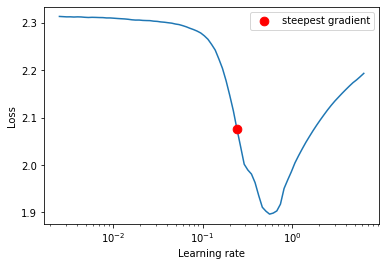

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc8c685bd50>,
 0.24201282647943811)

In [7]:
lr_finder.plot(log_lr=True)

LR suggestion: steepest gradient
Suggested LR: 2.42E-01


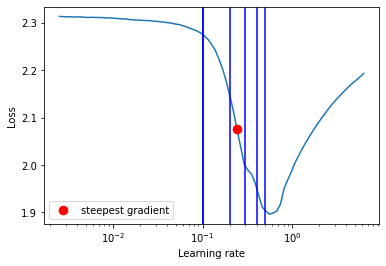

(<matplotlib.axes._subplots.AxesSubplot at 0x7fc8b971f210>,
 0.24201282647943811)

In [8]:
# Show some lrs
lr_finder.plot(log_lr=True, show_lr=[1e-1,  0.1, 0.2, 0.3, 0.4, 0.5])

In [22]:
# Evaluate weights after finding the lr
named_params = model.named_parameters()
for name, module in named_params:
    print(f'- Module {name}\n \t \t mean: {module.mean()} \n \t \t max: {module.max()} \n \t \t min: {module.min()}')

- Module conv1.weight
 	 	 mean: -0.5631905794143677 
 	 	 max: 1.0295658111572266 
 	 	 min: -7.622307777404785
- Module conv1.bias
 	 	 mean: -0.9652428030967712 
 	 	 max: 0.6579212546348572 
 	 	 min: -4.344000339508057
- Module conv2.weight
 	 	 mean: -0.3166534900665283 
 	 	 max: 0.1688554584980011 
 	 	 min: -37.87096405029297
- Module conv2.bias
 	 	 mean: -0.42159876227378845 
 	 	 max: -0.021250568330287933 
 	 	 min: -4.632826805114746
- Module fc1.weight
 	 	 mean: -0.11736834794282913 
 	 	 max: 0.8992581963539124 
 	 	 min: -26.487070083618164
- Module fc1.bias
 	 	 mean: -0.3351338803768158 
 	 	 max: -0.014729334972798824 
 	 	 min: -2.045773983001709
- Module fc2.weight
 	 	 mean: -0.004810352344065905 
 	 	 max: 2.647152900695801 
 	 	 min: -7.845766544342041
- Module fc2.bias
 	 	 mean: 0.015598462894558907 
 	 	 max: 0.3336434066295624 
 	 	 min: -0.4912267327308655


To restore the model and optimizer to their initial state use the `reset()` method.

In [10]:
lr_finder.reset()

In [11]:
# Evaluate weights after reseting the lr
named_params = model.named_parameters()
for name, module in named_params:
    print(f'- Module {name}\n \t \t mean: {module.mean()} \n \t \t max: {module.max()} \n \t \t min: {module.min()}')

- Module conv1.weight
 	 	 mean: 3.215736069250852e-05 
 	 	 max: 0.19959957897663116 
 	 	 min: -0.1992667019367218
- Module conv1.bias
 	 	 mean: 0.019651666283607483 
 	 	 max: 0.16063104569911957 
 	 	 min: -0.17914514243602753
- Module conv2.weight
 	 	 mean: -0.0006517112487927079 
 	 	 max: 0.06324551999568939 
 	 	 min: -0.06322894990444183
- Module conv2.bias
 	 	 mean: -0.0022223014384508133 
 	 	 max: 0.05429922044277191 
 	 	 min: -0.06234666705131531
- Module fc1.weight
 	 	 mean: -0.00022833132243249565 
 	 	 max: 0.05589595437049866 
 	 	 min: -0.05590146407485008
- Module fc1.bias
 	 	 mean: -0.005663219839334488 
 	 	 max: 0.05146395415067673 
 	 	 min: -0.05483570694923401
- Module fc2.weight
 	 	 mean: 0.0023726827930659056 
 	 	 max: 0.14094178378582 
 	 	 min: -0.14012092351913452
- Module fc2.bias
 	 	 mean: -0.03946481645107269 
 	 	 max: 0.12451539933681488 
 	 	 min: -0.13725951313972473


We can also run the test with a different starting learning rate without creating a new optimizer using the `start_lr` parameter.


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.09E-01


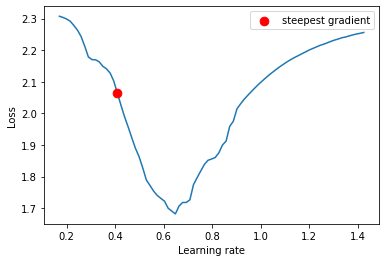

In [14]:
lr_finder.range_test(trainloader, start_lr=0.02, end_lr=1.5, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.62E-01


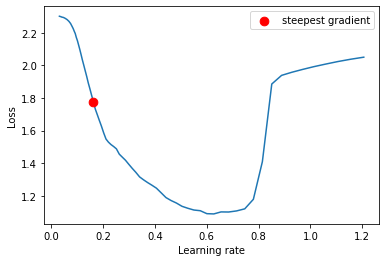

In [15]:
lr_finder.range_test(trainloader, start_lr=0.02, end_lr=1.5, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## Validation loss (Leslie N. Smith)

If a dataloader is passed to `LRFinder.range_test()` through the `val_loader` parameter the model is evaluated on that dataset after each iteration. The evaluation loss is more sensitive to instability therefore it provides a more precise view of when the divergence occurs. The disadvantage is that it takes significantly longer to run.

This version of the learning rate range test is described in [Cyclical Learning Rates for Training Neural Networks by Leslie N. Smith](https://arxiv.org/abs/1506.01186).

In [19]:
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=10, num_iter=100, step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


Note that the loss in the loss vs. learning rate plot is the **evaluation** loss.

LR suggestion: steepest gradient
Suggested LR: 2.54E-03


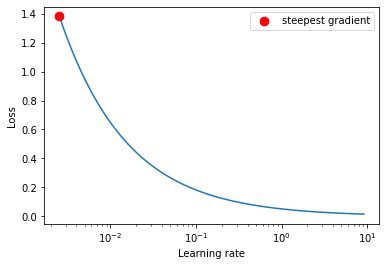

In [20]:
lr_finder.plot(skip_end=1)

To restore the model and optimizer to their initial state use the `reset()` method.

In [21]:
lr_finder.reset()


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.01E-03


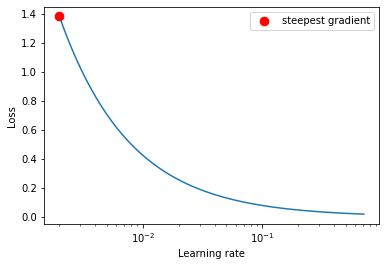

In [32]:
# Linear
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

# Evaluate found learning rates 

In [97]:
criterion = nn.NLLLoss()


def train_one_epoch(model, optimizer, epoch=0):
    model.train()
    total_loss = 0. 
    for iter, (imgs, targets) in enumerate(trainloader):
        if iter > 1000:
            break
        imgs = imgs.cuda()
        targets = targets.cuda()
        
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().cpu().item()
        
    print(f'\n[Training| Epoch {epoch}|  loss: {total_loss/(iter+1)}')
    
    return model

def evaluation(model):
    total_loss = 0.
    model.eval()
    for iter, (imgs, targets) in enumerate(testloader):
        imgs = imgs.cuda()
        targets = targets.cuda() 
        
        with torch.no_grad():
            outputs = model(imgs)
        loss = criterion(outputs, targets)
        total_loss += loss
    print(f'\n[Eval] Avg loss: {total_loss/len(testloader)}\n===============')


In [98]:
lrs = [2.42e-1, 4.09e-1, 1.62e-1, 2.54e-3, 2.01e-3]   

import torch
import pdb 
torch.manual_seed(0)
for lr in lrs:
    print(f'\n==================== LR = {lr} ======================\n')
    model = Net().cuda()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.5)
    
    for epoch in range(3):
        trained_model = train_one_epoch(model, optimizer, epoch)
    
        evaluation(trained_model)


==================== LR = 0.242 ======================


[Training| Epoch 0|  loss: 0.5596843419556922

[Eval] Avg loss: 0.12352388352155685

[Training| Epoch 1|  loss: 0.2682568329445859

[Eval] Avg loss: 0.07258277386426926

[Training| Epoch 2|  loss: 0.22360476239564572

[Eval] Avg loss: 0.06536003202199936

==================== LR = 0.409 ======================


[Training| Epoch 0|  loss: 0.7231562564981745

[Eval] Avg loss: 0.11664595454931259

[Training| Epoch 1|  loss: 0.3759063603396111

[Eval] Avg loss: 0.1170477494597435

[Training| Epoch 2|  loss: 0.32550881872785853

[Eval] Avg loss: 0.10846175998449326

==================== LR = 0.162 ======================


[Training| Epoch 0|  loss: 0.5673917628349142

[Eval] Avg loss: 0.13004760444164276

[Training| Epoch 1|  loss: 0.27389642336267106

[Eval] Avg loss: 0.07550141960382462

[Training| Epoch 2|  loss: 0.22202362979346132

[Eval] Avg loss: 0.062488801777362823

==================== LR = 0.00254 ======================


